In [2]:
from sklearn import datasets
from sklearn.cross_validation import train_test_split
from scipy import io as sio
from tensorflow.python.framework import ops
from dfs2 import DeepFeatureSelectionNew
import numpy as np
from sklearn.datasets import make_classification
from sklearn.preprocessing import normalize

ourdataB = sio.loadmat("/Users/xupeng.tong/Documents/Data/OriginalData/newDataB_2labels.mat")
inputX = ourdataB['X']
inputX = normalize(inputX, axis=0)
inputY = ourdataB['Y'][0,:]
columnNames = ourdataB['columnNames']

# iris = datasets.load_iris()
# inputX = iris.data[:,[1,2,3]]
# inputY = iris.target

# digits = datasets.load_digits()
# inputX = digits.data  
# inputY = digits.target

# inputX, inputY = make_classification(n_samples=1000, n_features=7500, n_informative=3000, n_redundant=0, n_repeated=0, n_classes=2)

X_train, X_test, y_train, y_test = train_test_split(inputX, inputY, test_size=0.2, random_state=42)

In [36]:
inputX

array([[ 0.01143719,  0.00839743,  0.01043568, ...,  0.00818266,
         0.01408974,  0.0096754 ],
       [ 0.01143719,  0.        ,  0.01043568, ...,  0.00818266,
         0.00704487,  0.0096754 ],
       [ 0.01143719,  0.01679487,  0.01043568, ...,  0.00818266,
         0.00704487,  0.0096754 ],
       ..., 
       [ 0.00571859,  0.        ,  0.01043568, ...,  0.00956141,
         0.00704487,  0.0096754 ],
       [ 0.01143719,  0.00839743,  0.01043568, ...,  0.00818266,
         0.00704487,  0.0096754 ],
       [ 0.01143719,  0.00839743,  0.01043568, ...,  0.00818266,
         0.00704487,  0.0096754 ]])

In [59]:
# ops.reset_default_graph()

# dfsMLP = DeepFeatureSelectionNew(X_train5, X_test5, y_train, y_test, n_input=0, hidden_dims=[100], learning_rate=0.01, \
#                                  lambda1=0.001, lambda2=0.1, alpha1=0.01, alpha2=0.05, \
#                                  weight_init='mlp',epochs=100000, optimizer='Adam', print_step=100)

# dfsMLP.train(batch_size=1000)

In [63]:
from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils

batch_size = 2000
nb_classes = 2
nb_epoch = 500

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

model = Sequential()
model.add(Dense(300, input_shape=(500,)))
model.add(Activation('sigmoid'))
model.add(Dense(2))
model.add(Activation('softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history = model.fit(X_train500, Y_train,
                    batch_size=batch_size, nb_epoch=nb_epoch,
                    verbose=1, validation_data=(X_test500, Y_test))
score = model.evaluate(X_test500, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
dense_7 (Dense)                    (None, 300)         150300      dense_input_4[0][0]              
____________________________________________________________________________________________________
activation_7 (Activation)          (None, 300)         0           dense_7[0][0]                    
____________________________________________________________________________________________________
dense_8 (Dense)                    (None, 2)           602         activation_7[0][0]               
____________________________________________________________________________________________________
activation_8 (Activation)          (None, 2)           0           dense_8[0][0]                    
Total params: 150902
______________________________________________________________________

In [64]:
Y_train

array([[ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       ..., 
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.]])

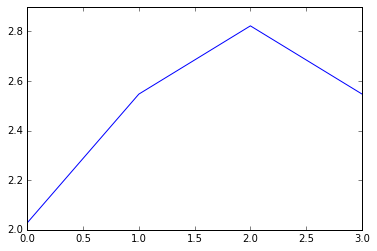

In [44]:
%matplotlib inline

import matplotlib.pyplot as plt

temp = abs(dfsMLP.selected_ws[0])

plt.plot(temp)

In [5]:
temp = dfsMLP.selected_ws

temp1, temp2 = temp[0], temp[1]

In [9]:
np.where(abs(temp1)<0.01)

(array([ 0,  1,  7,  8, 15, 16, 17, 20, 23, 24, 25, 31, 32, 36, 38, 39, 40,
        41, 47, 48, 55, 56, 57, 62, 63]),)

In [10]:
np.where(abs(temp2)<0.01)

(array([ 0,  1,  7,  8, 11, 14, 15, 16, 17, 22, 23, 24, 31, 32, 36, 38, 39,
        40, 41, 44, 47, 48, 49, 51, 55, 56, 57, 59, 63]),)

In [12]:
temp = dfsMLP.selected_ws

temp3, temp4 = temp[0], temp[1]

print(np.where(abs(temp3)<0.01))
print(np.where(abs(temp4)<0.01))

(array([ 0,  1,  6,  7,  8,  9, 15, 16, 23, 24, 30, 31, 32, 39, 40, 41, 46,
       47, 48, 49, 55, 56, 57, 63]),)
(array([ 0,  1,  7,  8,  9, 12, 15, 16, 22, 23, 24, 30, 31, 32, 34, 38, 39,
       40, 41, 46, 47, 48, 49, 55, 56, 57, 63]),)


In [14]:
temp = dfsMLP.selected_ws

temp5, temp6 = temp[0], temp[1]

print(np.where(abs(temp5)<0.01))
print(np.where(abs(temp6)<0.01))

(array([ 0,  1,  6,  7,  8,  9, 10, 15, 16, 18, 23, 24, 25, 28, 30, 31, 32,
       33, 35, 36, 39, 40, 41, 44, 45, 46, 47, 48, 49, 51, 55, 56, 57, 60,
       61, 63]),)
(array([ 0,  1,  6,  7,  8,  9, 10, 15, 16, 18, 23, 24, 25, 28, 30, 31, 32,
       33, 35, 36, 39, 40, 41, 44, 45, 46, 47, 48, 49, 51, 55, 56, 57, 60,
       61, 63]),)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import xgboost as xgb

# rf = RandomForestClassifier(criterion="entropy", n_estimators = 300, max_depth = 100)
# rf.fit(X_train, y_train)

# y_pred = rf.predict(X_test)

# gbm = xgb.XGBClassifier(max_depth=3, n_estimators=400, learning_rate=0.05).fit(X_train, y_train)
# y_pred = gbm.predict(X_test)

# print(accuracy_score(y_test, y_pred))

gbm10 = xgb.XGBClassifier(max_depth=3, n_estimators=400, learning_rate=0.05).fit(X_train10, y_train)
y_pred10 = gbm.predict(X_test10)

print(accuracy_score(y_test, y_pred))

In [46]:
indexes = np.argsort(gbm.feature_importances_)[::-1]

top100Features = np.array([columnNames[0][i] for i in indexes[0:200]])
# top100Features = np.array([columnNames[i] for i in indexes[0:100]])
# top100Features = top100Features.reshape(100,)

array([ 0.0071736 ,  0.00382592,  0.        , ...,  0.        ,
        0.        ,  0.04351985], dtype=float32)

In [18]:
X_train500, X_test500 = X_train[:, indexes[:500]], X_test[:, indexes[:500]]
    
X_train10, X_test10 = X_train[:, indexes[:10]], X_test[:, indexes[:10]]

In [57]:
X_train5, X_test5 = X_train[:, indexes[:5]], X_test[:, indexes[:5]]

In [33]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(loss="log", penalty="l1")

clf.fit(X_train500, y_train)

y_pred500lr = clf.predict(X_test500)

print(accuracy_score(y_test, y_pred500lr))

0.65933551708
